Import Libraries

In [1]:
#TensorFlow is used for building the CNN model, while 
# scikit-learn is used for data preprocessing. 
# Pandas handles data manipulation 
# and joblib is used to save model components (scaler and label encoder).
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Reshape, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib  # For saving scaler and label encoder

Load and extract features and labels from provided features_3_sec csv file

In [2]:
features_df = pd.read_csv("../../Misc/features_3_sec.csv")
X = features_df.drop(columns=['filename','label']).values  # Drop 'label' column and take all features
y = features_df['label'].values  # 'label' column contains the target classes (genres)

Encode and Normalize

In [3]:
# ML models generally work with numerical data, so we need to encode the music genres (which are categorical) into numerical labels. 
# The LabelEncoder will map each unique genre to an integer.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Classes: ", label_encoder.classes_)

# Save the encoder so it can be reused after transforming the labels 
# later (for example, during model inference).
joblib.dump(label_encoder, 'label_encoder.pkl')
print("LabelEncoder saved successfully.")

# Normalize the features to ensure that each feature has zero mean and unit variance. This is important for many machine learning algorithms, as 
# it ensures that no feature dominates the model due to differences in scale.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the fitted scaler  using joblib for future use.
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved successfully.")

Classes:  ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
LabelEncoder saved successfully.
Scaler saved successfully.


spilt into Train and Test set

In [4]:
#Split the data into a training set (80%) and a testing set (20%) using the train_test_split function. 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Output the shape of the training and testing data to verify the split.
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (7992, 58)
Testing data shape: (1998, 58)


Define the CNN model 

In [5]:

# Initialize the model
model = Sequential()

# Reshape the input to have a 3D shape (samples, timesteps, features) for Conv1D layers
# We add an extra dimension since Conv1D expects a 3D input.
model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

# First Conv1D layer with 32 filters, a kernel size of 3, ReLU activation, and L2 regularization
model.add(Conv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# Batch normalization to help stabilize training by normalizing activations
model.add(BatchNormalization())
# Max-pooling layer to down-sample the feature map
model.add(MaxPooling1D(2))

# Second Conv1D layer with 64 filters, kernel size of 3, ReLU activation, and L2 regularization
model.add(Conv1D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
# Another max-pooling layer
model.add(MaxPooling1D(2))

# Flatten the feature map to create a 1D vector, which is required for the dense layers
model.add(Flatten())
# Dense layer with 64 units, ReLU activation, and L2 regularization
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# Dropout layer to prevent overfitting by randomly dropping 30% of the neurons
model.add(Dropout(0.3))
# Output layer with softmax activation for multi-class classification
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

# Compile the model using Adam optimizer with a learning rate of 0.001 and sparse categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display a summary of the model architecture
model.summary()

c:\MyWork\Tech-Work\SDS\SDS-CP018-music-classifier\.venv\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 58, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 56, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 56, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 28, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 26, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 832)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,682 (237.04 KB)

 Trainable params: 60,490 (236.29 KB)

 Non-trainable params: 192 (768.00 B)

Define early stopping callback

In [6]:
# Early stopping is a callback function that helps prevent overfitting by stopping 
# the training process if the validation loss doesn't improve after a certain 
# number of epochs (patience=5). This will restore the best weights based on 
# the validation performance.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Train and save the model

In [7]:
#train the model using the training data.
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# save the model to disk using the .save() method. 
model.save('music_genre_cnn_model.h5')
print("Model saved successfully.")

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4259 - loss: 1.8788 - val_accuracy: 0.4489 - val_loss: 1.8599
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6839 - loss: 1.0789 - val_accuracy: 0.6552 - val_loss: 1.2793
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7392 - loss: 0.9076 - val_accuracy: 0.7508 - val_loss: 0.9288
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7903 - loss: 0.7863 - val_accuracy: 0.8003 - val_loss: 0.7658
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8206 - loss: 0.6970 - val_accuracy: 0.8303 - val_loss: 0.6892
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8460 - loss: 0.6111 - val_accuracy: 0.8288 - val_loss: 0.6643
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8636 - loss: 0.5595 - val_accuracy: 0.8473 - val_loss: 0.6269
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8763 - loss: 0.5215 - val_accuracy

Model saved successfully.


Evaluate the model on the test data

In [10]:
# evaluate the trained model on the test set to determine its performance 
# in terms of accuracy. This gives us an indication of how well the model 
# generalizes to unseen data.
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

63/63 - 0s - 3ms/step - accuracy: 0.8809 - loss: 0.5571
Test accuracy: 0.8809


Plot training history for accuracy and loss

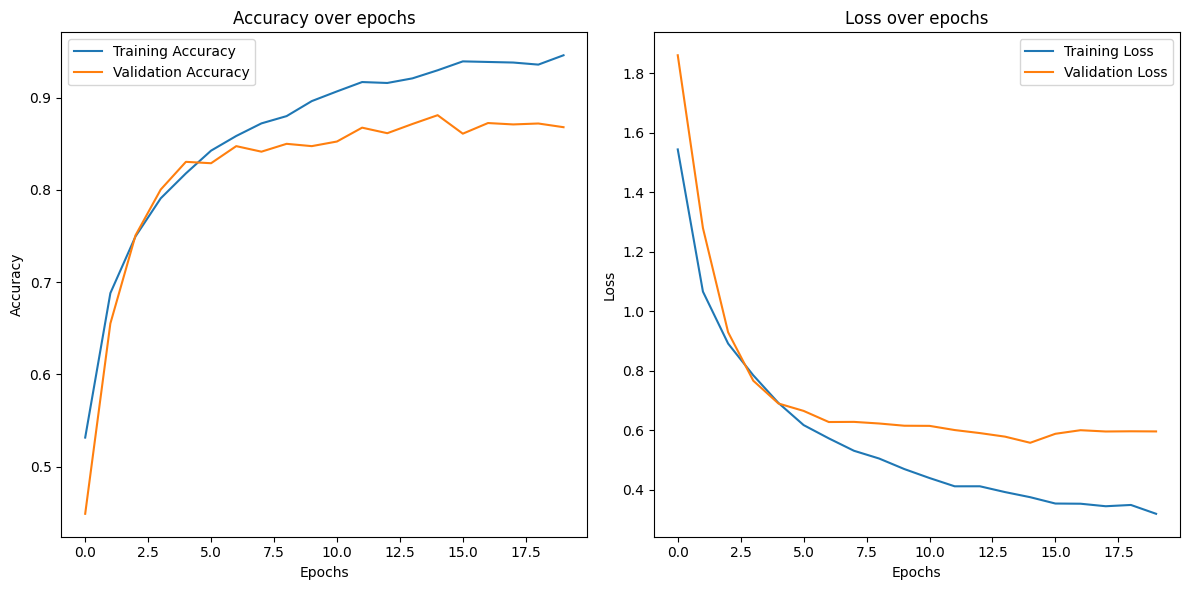

In [9]:
# plot the training and validation accuracy and loss over epochs to visualize 
# how the model improved during training. This can help identify potential 
# issues like overfitting or underfitting.
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()